In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import tempfile
from sklearn.metrics import confusion_matrix
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

## Describe the problem

Dataset used: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset  

I will use the dataset to predict whether a patient is likely to get stroke, based on various parameters such as age, gender, diseases etc.  

## Analyze the data

In [186]:
df = pd.read_csv("data.csv")
init_shape = df.shape
TARGET = "stroke"
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [187]:
df.shape

(5110, 12)

### Create plot functions

In [188]:
def ratioPlot(df,name):
    df_to_plot = df[name].value_counts()
    df_to_plot.plot.barh(color="#21252B")
    for index, value in enumerate(df_to_plot):
        plt.text(value, index, str(value),ha="left",va="center")
    plt.show()
    df_to_plot = df[[name,TARGET]].groupby([name]).value_counts()
    df_to_plot.plot.barh(color="#21252B")
    for index, value in enumerate(df_to_plot):
            plt.text(value, index, str(value),ha="left",va="center")

    plt.show()        
    
def ratioPrint(df,name):
    print("LABELS")
    total = df.shape[0]
    for index,label in zip(df[name].unique(),df[name].value_counts()):
        print(" ",index,"->",label,",",f'{int(label/total*100)}%')
    print()
    print("LABELS WITH STROKE")
    labels = df[[name,TARGET]].groupby([name]).value_counts().keys()
    labels_total = df[[name,TARGET]].groupby(name).count()[TARGET]
    cnt = 0
    for index,label in zip(labels,df[[name,TARGET]].groupby([name]).value_counts()):
        print(" ",index,"->",label,",",f'{int(label/total*100)}%',f'{int(label/labels_total.iloc[cnt//2]*100)}%')
        cnt+=1
    

### Stroke

Check healthy to ill ratio

([<matplotlib.patches.Wedge at 0x1fc02d8a3a0>,
 [Text(-1.0870328243268486, 0.16840320316429608, 'HEALTHY'),
  Text(1.185853994474847, -0.18371255751322516, 'ILL')],
 [Text(-0.5929269950873718, 0.09185629263507057, '95.1%'),
  Text(0.6917481634436606, -0.10716565854938134, '4.9%')])

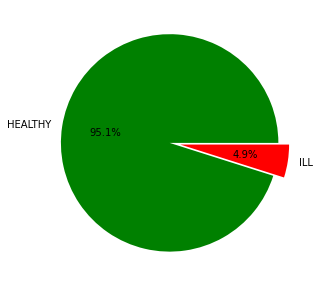

In [189]:
plt.pie(df[TARGET].value_counts(), autopct='%1.1f%%', explode=[0,0.1], labels=["HEALTHY","ILL"], colors=["green","red"])

As expected a great deal more patients are healthy. Such a huge difference may be problematic during training the models. That's why I will focus mostly on recall as my go-to metric

### Id

Completely useless. Will be deleted

In [190]:
df.drop("id",axis = 1, inplace = True)

### Gender

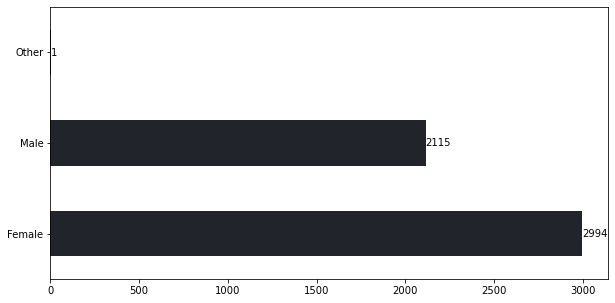

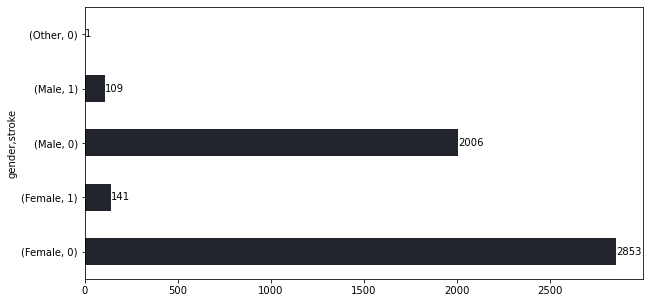

In [191]:
ratioPlot(df,"gender")

In [192]:
ratioPrint(df,"gender")

LABELS
  Male -> 2994 , 58%
  Female -> 2115 , 41%
  Other -> 1 , 0%

LABELS WITH STROKE
  ('Female', 0) -> 2853 , 55% 95%
  ('Female', 1) -> 141 , 2% 4%
  ('Male', 0) -> 2006 , 39% 94%
  ('Male', 1) -> 109 , 2% 5%
  ('Other', 0) -> 1 , 0% 100%


In [193]:
df.drop(df.index[df["gender"] == "Other"], inplace=True)
df["gender"].replace(["Male","Female"],[0,1],inplace=True)

Since there is only one Other in gender column we can delete it to simplify the data. Also we replace Male/Female with 0/1 so third option would be problematic

### Age

In [194]:
df["age"].nunique()

104

Since the're so many different values for age, I will divide them into groups (0 - the youngest group, 5 - the oldest)

In [195]:
df['age'] = pd.qcut(df['age'], q=[0, .3, .6, .7, .8, .9, 1], labels=[0,1,2,3,4,5])
ratioPrint(df,'age')

LABELS
  4 -> 1569 , 30%
  3 -> 1499 , 29%
  5 -> 559 , 10%
  1 -> 517 , 10%
  2 -> 500 , 9%
  0 -> 465 , 9%

LABELS WITH STROKE
  (0, 0) -> 1566 , 30% 99%
  (0, 1) -> 3 , 0% 0%
  (1, 0) -> 1474 , 28% 98%
  (1, 1) -> 25 , 0% 1%
  (2, 0) -> 491 , 9% 94%
  (2, 1) -> 26 , 0% 5%
  (3, 0) -> 519 , 10% 92%
  (3, 1) -> 40 , 0% 7%
  (4, 0) -> 440 , 8% 88%
  (4, 1) -> 60 , 1% 12%
  (5, 0) -> 369 , 7% 79%
  (5, 1) -> 96 , 1% 20%


As can be seen, with greater age comes higher probability of being victim of a stroke

### Hypertension and heart disease

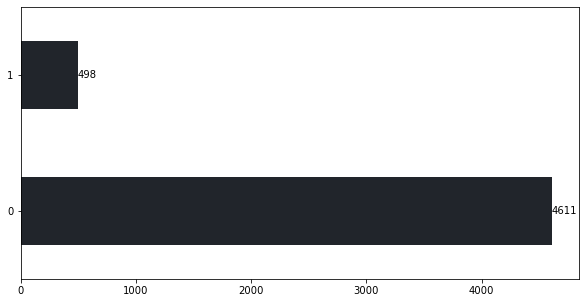

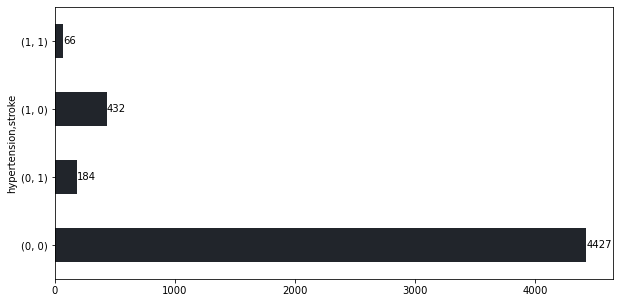

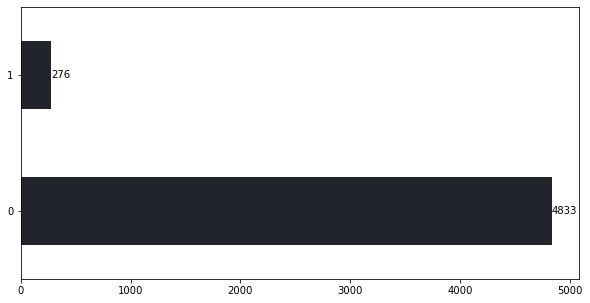

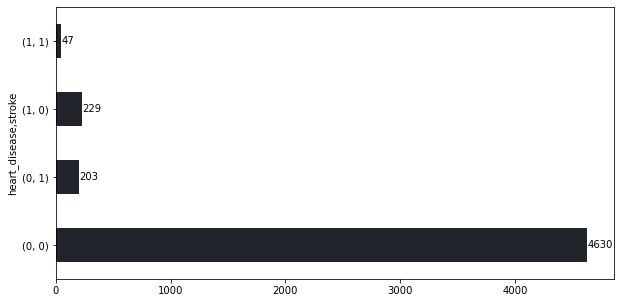

In [196]:
ratioPlot(df,"hypertension"),
ratioPlot(df,"heart_disease")

In [197]:
ratioPrint(df,"hypertension"),
print(),print(),
ratioPrint(df,"heart_disease")

LABELS
  0 -> 4611 , 90%
  1 -> 498 , 9%

LABELS WITH STROKE
  (0, 0) -> 4427 , 86% 96%
  (0, 1) -> 184 , 3% 3%
  (1, 0) -> 432 , 8% 86%
  (1, 1) -> 66 , 1% 13%


LABELS
  1 -> 4833 , 94%
  0 -> 276 , 5%

LABELS WITH STROKE
  (0, 0) -> 4630 , 90% 95%
  (0, 1) -> 203 , 3% 4%
  (1, 0) -> 229 , 4% 82%
  (1, 1) -> 47 , 0% 17%


Hypertension and heart disease affect greatly the chance of patient having a stroke  
Maybe patients with both of these will have even greater chance?

In [198]:
def merge_cols(x,y):
    if x == 1 and y == 1:
        return 1
    else:
        return 0

df["hypertension and heart-disease"] = df.apply(lambda x: merge_cols(x["hypertension"],x["heart_disease"]),axis = 1)
ratioPrint(df,"hypertension and heart-disease")

LABELS
  0 -> 5045 , 98%
  1 -> 64 , 1%

LABELS WITH STROKE
  (0, 0) -> 4808 , 94% 95%
  (0, 1) -> 237 , 4% 4%
  (1, 0) -> 51 , 0% 79%
  (1, 1) -> 13 , 0% 20%


The chance is a bit higher

### Ever Married

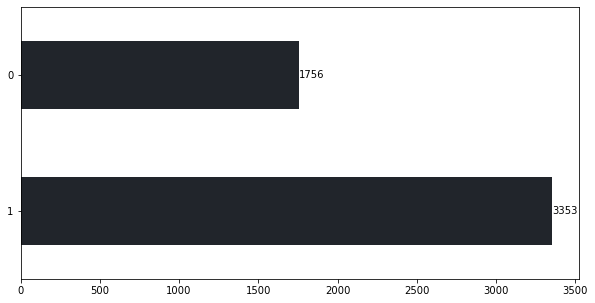

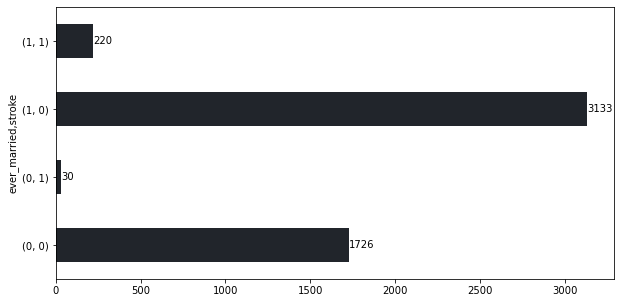

In [199]:
df["ever_married"].replace(["No","Yes"],[0,1],inplace=True)
ratioPlot(df,"ever_married")

In [200]:
ratioPrint(df,'ever_married')

LABELS
  1 -> 3353 , 65%
  0 -> 1756 , 34%

LABELS WITH STROKE
  (0, 0) -> 1726 , 33% 98%
  (0, 1) -> 30 , 0% 1%
  (1, 0) -> 3133 , 61% 93%
  (1, 1) -> 220 , 4% 6%


### Work Type

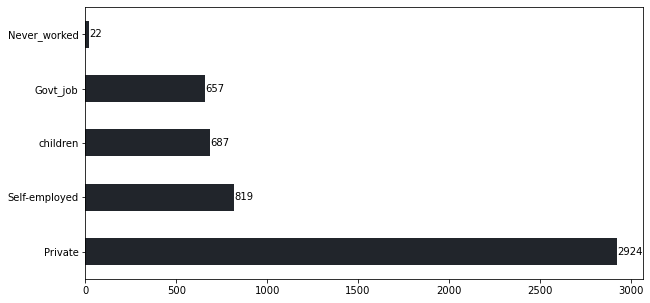

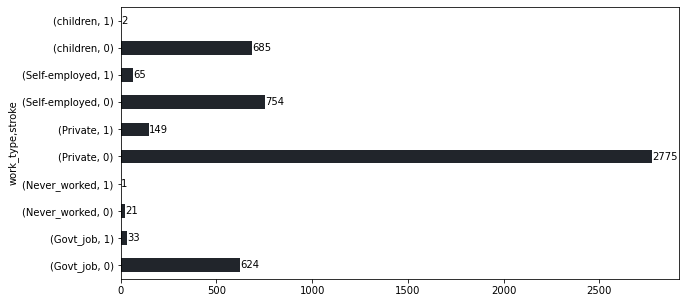

In [201]:
ratioPlot(df,"work_type")

In [202]:
ratioPrint(df,"work_type")

LABELS
  Private -> 2924 , 57%
  Self-employed -> 819 , 16%
  Govt_job -> 687 , 13%
  children -> 657 , 12%
  Never_worked -> 22 , 0%

LABELS WITH STROKE
  ('Govt_job', 0) -> 624 , 12% 94%
  ('Govt_job', 1) -> 33 , 0% 5%
  ('Never_worked', 0) -> 21 , 0% 95%
  ('Never_worked', 1) -> 1 , 0% 4%
  ('Private', 0) -> 2775 , 54% 94%
  ('Private', 1) -> 149 , 2% 5%
  ('Self-employed', 0) -> 754 , 14% 92%
  ('Self-employed', 1) -> 65 , 1% 7%
  ('children', 0) -> 685 , 13% 99%
  ('children', 1) -> 2 , 0% 0%


In [203]:
work_dummies = pd.get_dummies(df["work_type"], prefix='Country')
df.drop("work_type",axis = 1, inplace=True)


### Residence type

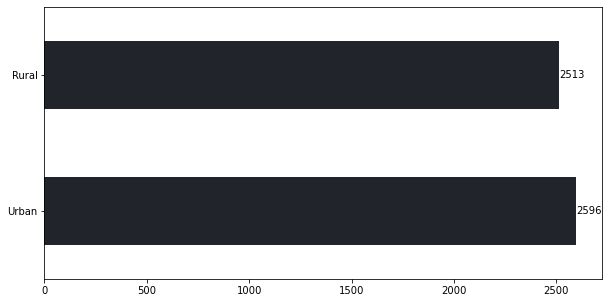

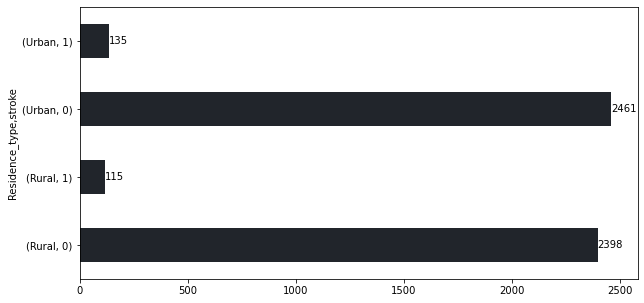

In [204]:
ratioPlot(df,"Residence_type")

In [205]:
ratioPrint(df,"Residence_type")

LABELS
  Urban -> 2596 , 50%
  Rural -> 2513 , 49%

LABELS WITH STROKE
  ('Rural', 0) -> 2398 , 46% 95%
  ('Rural', 1) -> 115 , 2% 4%
  ('Urban', 0) -> 2461 , 48% 94%
  ('Urban', 1) -> 135 , 2% 5%


In [206]:
df["Residence_type"].replace(["Rural","Urban"],[1,0],inplace=True)

### Glucose

In [207]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df["avg_glucose_level"] = scaler.fit_transform(df["avg_glucose_level"].to_numpy().reshape(-1,1))

### BMI

BMI relies greatly on gender and age  
I will use those to fill NaNs and then scale it

In [208]:
bmi_df = df[["age","gender","bmi"]]
median_bmi = bmi_df.groupby(["gender","age"]).median()["bmi"]
index = df['bmi'].index[df['bmi'].apply(np.isnan)]
new_bmi = []
for i in range(init_shape[0]):
    if i in index:
        bmi = median_bmi[df.loc[i]["gender"],df.loc[i]["age"]]
        new_bmi.append(bmi)
    else:
        try:
            bmi = df.loc[i]["bmi"]
            new_bmi.append(bmi)
        except KeyError:
            pass
df["bmi"] = new_bmi
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df["bmi"] = scaler.fit_transform(df["bmi"].to_numpy().reshape(-1, 1))

### Smoking status

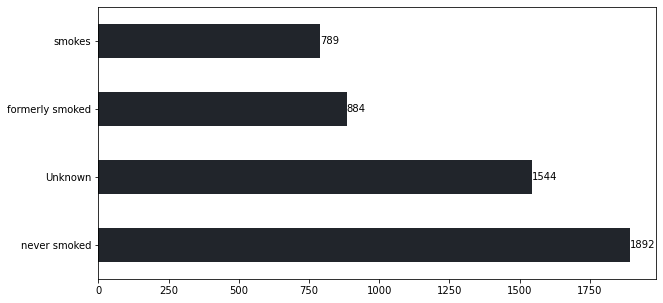

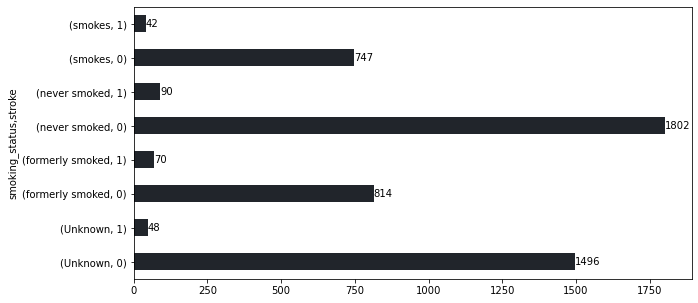

In [209]:
ratioPlot(df,"smoking_status")

In [210]:
ratioPrint(df,"smoking_status")

LABELS
  formerly smoked -> 1892 , 37%
  never smoked -> 1544 , 30%
  smokes -> 884 , 17%
  Unknown -> 789 , 15%

LABELS WITH STROKE
  ('Unknown', 0) -> 1496 , 29% 96%
  ('Unknown', 1) -> 48 , 0% 3%
  ('formerly smoked', 0) -> 814 , 15% 92%
  ('formerly smoked', 1) -> 70 , 1% 7%
  ('never smoked', 0) -> 1802 , 35% 95%
  ('never smoked', 1) -> 90 , 1% 4%
  ('smokes', 0) -> 747 , 14% 94%
  ('smokes', 1) -> 42 , 0% 5%


In [211]:
smoking_dummies = pd.get_dummies(df["smoking_status"], prefix='Smoking')
df.drop("smoking_status",axis = 1, inplace=True)

### Final observations

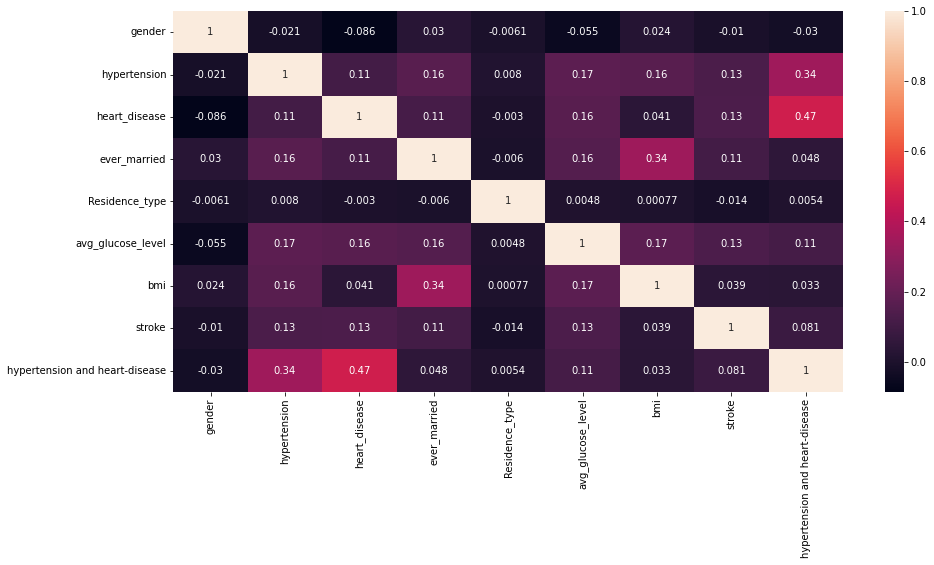

In [212]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True)
df = pd.concat([df,smoking_dummies],axis = 1)
df = pd.concat([df,work_dummies],axis = 1)

## Model training

### Baseline model

In [213]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [214]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Input
from keras import Model, metrics
from keras.regularizers import L1L2,L1,L2
tf.config.set_visible_devices([], 'GPU')

def create_model(lr,rr, X_train, dropout):
    inp = Input(shape=(X_train.shape[1]))

    x = Dense(units = 64, activation = "relu", kernel_regularizer = L1(rr))(inp)
        
    x = Dropout(rate = dropout)(x)
        
    x = Dense(units = 32, activation = "relu", kernel_regularizer = L1(rr))(x)
        
    x = Dense(units = 16, activation = "relu", kernel_regularizer = L1(rr))(x)
        
    x = Dense(units = 1, activation = "sigmoid")(x)
    
    optimizer = keras.optimizers.Adam(learning_rate = lr)
    loss = "mean_squared_error"

    model = Model(inp,x,name="stroke")
    model.compile(
        optimizer = optimizer,
        loss = loss,
        metrics = [
            keras.metrics.BinaryAccuracy(name='accuracy'),
            "AUC",
            keras.metrics.Recall(name='recall'),
            
        ]
    )
    
    return model
    
def train_model(model,x,y,epochs,batch_size,validation_split,class_weight = None):
    history = model.fit(
        x = x,
        y = y,
        epochs = epochs,
        batch_size = batch_size,
        shuffle = True,
        validation_split = validation_split,
        class_weight = class_weight
    )
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist    
    
def plot_output(epochs,hist,list_of_metrics):
    plt.figure(figsize=(10,5))
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.ylim([0, 1])
    
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()
    plt.show()
    
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

Epoch 1/25
23/23 [==============================] - 1s 12ms/step - loss: 1.6002 - accuracy: 0.9147 - auc: 0.4286 - recall: 0.1077 - val_loss: 1.4588 - val_accuracy: 0.9396 - val_auc: 0.2142 - val_recall: 0.0000e+00
Epoch 2/25
23/23 [==============================] - 0s 2ms/step - loss: 1.3365 - accuracy: 0.9545 - auc: 0.3130 - recall: 0.0000e+00 - val_loss: 1.2348 - val_accuracy: 0.9396 - val_auc: 0.1728 - val_recall: 0.0000e+00
Epoch 3/25
23/23 [==============================] - 0s 2ms/step - loss: 1.1323 - accuracy: 0.9545 - auc: 0.2617 - recall: 0.0000e+00 - val_loss: 1.0434 - val_accuracy: 0.9396 - val_auc: 0.1682 - val_recall: 0.0000e+00
Epoch 4/25
23/23 [==============================] - 0s 2ms/step - loss: 0.9488 - accuracy: 0.9545 - auc: 0.2635 - recall: 0.0000e+00 - val_loss: 0.8695 - val_accuracy: 0.9396 - val_auc: 0.1655 - val_recall: 0.0000e+00
Epoch 5/25
23/23 [==============================] - 0s 2ms/step - loss: 0.7820 - accuracy: 0.9545 - auc: 0.2915 - recall: 0.0000e+0

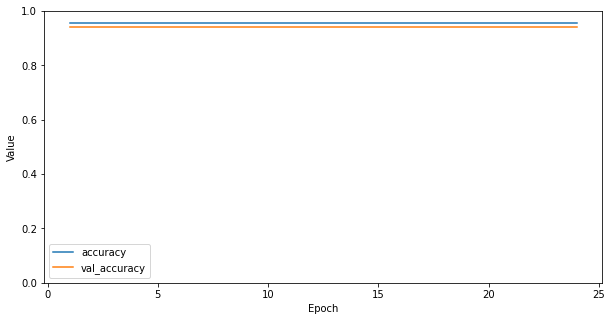

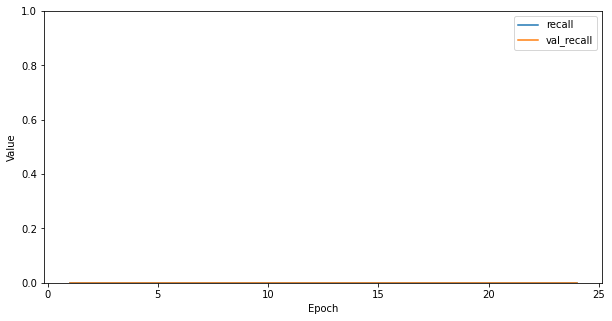

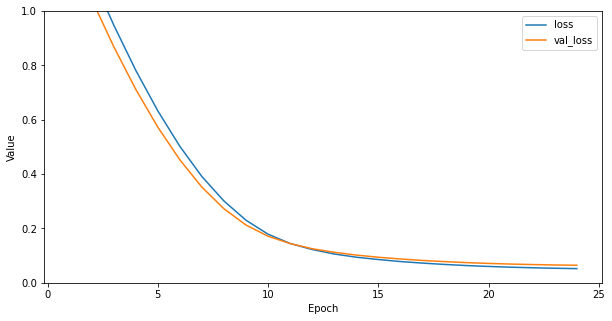

In [215]:
learning_rate =  0.001
dropout = 0.4
batch_size = 64
epochs = 25
validation_split = 0.3
regularization_rate = 0.003
bias = np.log(2)

X_train, X_test, y_train, y_test = train_test_split(df.drop("stroke", axis= 1).to_numpy().astype(float),df["stroke"].to_numpy().astype(float), train_size = 0.4)

baseline_model = create_model(learning_rate,regularization_rate,X_train,dropout)
epochs, hist = train_model(baseline_model,X_train,y_train,epochs,batch_size,validation_split)

plot_output(epochs,hist,["accuracy","val_accuracy"])
plot_output(epochs,hist,["recall","val_recall"])
plot_output(epochs,hist,["loss","val_loss"])

96/96 [==============================] - 0s 558us/step


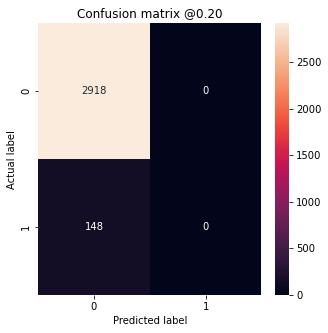

In [216]:
baseline_predictions = baseline_model.predict(X_test)
plot_cm(y_test,baseline_predictions, p = 0.2)

In [217]:
for name, value in zip(baseline_model.metrics_names, baseline_model.evaluate(X_test, y_test, verbose = 0)):
      print(name, ': ', value)

loss :  0.053975775837898254
accuracy :  0.9517286419868469
auc :  0.5
recall :  0.0


Due to the imbalance the model performs extremely poorly  
The precision is very high, because 95% of the patients in database are healthy. In such case, when model predicts the dominant label for all of the cases it should get precision equal to the ratio of the dominant label to all labels in databse. Since the precision is 95% in my case, with literally 0% recall, the imbalance is definitely a problem.

In [218]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
baseline_model.save_weights(initial_weights)

### Class weights

In [219]:
values = df["stroke"].value_counts()
pos,neg = values[1],values[0]
total = pos+neg
w1 = (1/pos) * (total / 2)
w0 = (1/neg) * (total / 2)
class_weight = {
    0: w0,
    1: w1
}

Epoch 1/50
26/26 [==============================] - 1s 11ms/step - loss: 0.3963 - accuracy: 0.9523 - auc: 0.5543 - recall: 0.0000e+00 - val_loss: 0.1063 - val_accuracy: 0.9413 - val_auc: 0.8130 - val_recall: 0.0000e+00
Epoch 2/50
26/26 [==============================] - 0s 2ms/step - loss: 0.2924 - accuracy: 0.9523 - auc: 0.5269 - recall: 0.0000e+00 - val_loss: 0.2472 - val_accuracy: 0.9413 - val_auc: 0.5000 - val_recall: 0.0000e+00
Epoch 3/50
26/26 [==============================] - 0s 2ms/step - loss: 0.2764 - accuracy: 0.9523 - auc: 0.5184 - recall: 0.0000e+00 - val_loss: 0.2473 - val_accuracy: 0.9413 - val_auc: 0.7973 - val_recall: 0.0000e+00
Epoch 4/50
26/26 [==============================] - 0s 2ms/step - loss: 0.2704 - accuracy: 0.9523 - auc: 0.5202 - recall: 0.0000e+00 - val_loss: 0.2328 - val_accuracy: 0.9413 - val_auc: 0.6251 - val_recall: 0.0000e+00
Epoch 5/50
26/26 [==============================] - 0s 2ms/step - loss: 0.2659 - accuracy: 0.9523 - auc: 0.5950 - recall: 0.000

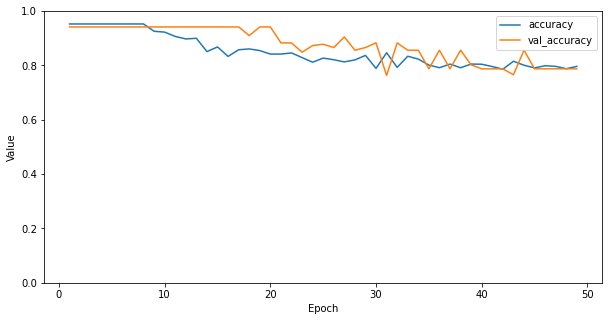

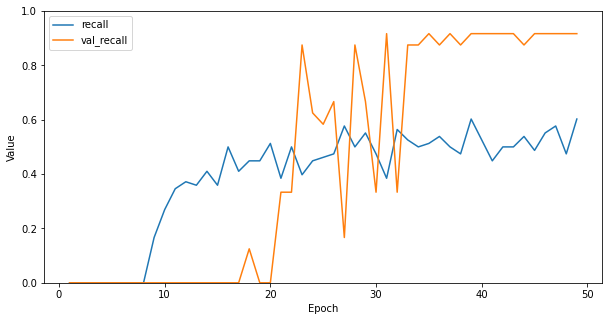

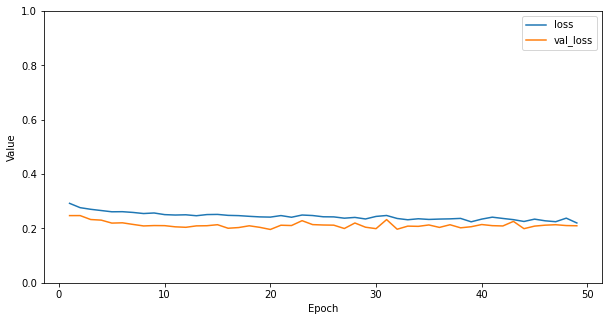

In [220]:
learning_rate =  0.0003
dropout = 0.4
batch_size = 64
epochs = 50
validation_split = 0.2
regularization_rate = 0.003
bias = np.log(2)

weighted_model = create_model(learning_rate,regularization_rate,X_train,dropout)
weighted_model.load_weights(initial_weights)

epochs, hist = train_model(weighted_model,X_train,y_train,epochs,batch_size,validation_split,class_weight=class_weight)
plot_output(epochs,hist,["accuracy","val_accuracy"])
plot_output(epochs,hist,["recall","val_recall"])
plot_output(epochs,hist,["loss","val_loss"])

96/96 [==============================] - 0s 537us/step


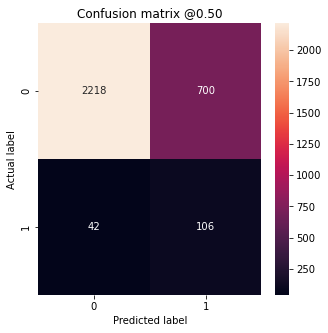

In [221]:
weighted_predictions = weighted_model.predict(X_test)
plot_cm(y_test,weighted_predictions, p = 0.5)

In [222]:
for name, value in zip(weighted_model.metrics_names, weighted_model.evaluate(X_test, y_test, verbose = 0)):
      print(name, ': ', value)

loss :  0.21490426361560822
accuracy :  0.7579908967018127
auc :  0.8022167086601257
recall :  0.7162162065505981


## Machine Learning Solutions

In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [228]:
models = {
    "Logistic Regression": LogisticRegression(solver='lbfgs', class_weight=class_weight),
    "SVC": LinearSVC(class_weight=class_weight),
    "Decision Tree": DecisionTreeClassifier(class_weight=class_weight),
    "Random Forest": RandomForestClassifier(class_weight=class_weight, n_estimators= 400),
}
accuracy = {}
recall = {}

for key in models.keys():
    print(key)
    models[key].fit(X_train, y_train)
    ml_prediction = models[key].predict(X_test)
    accuracy[key] = accuracy_score(ml_prediction, y_test)
    recall[key] = recall_score(ml_prediction, y_test)

Logistic Regression
SVC
Decision Tree
Random Forest


c:\Users\adamk\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [229]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Recall'] = recall.values()
df_model

,Accuracy,Recall
Logistic Regression,0.752772,0.125307
SVC,0.744292,0.123223
Decision Tree,0.917156,0.115942
Random Forest,0.948467,0.187500


Even with class weights, these models perform very poorly compared to the tensorflow model